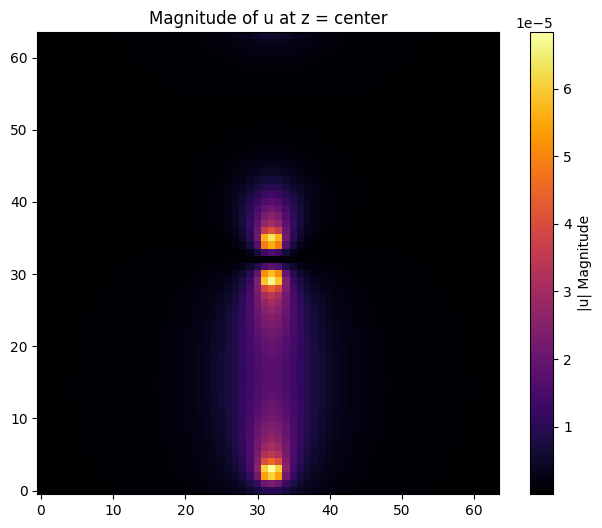

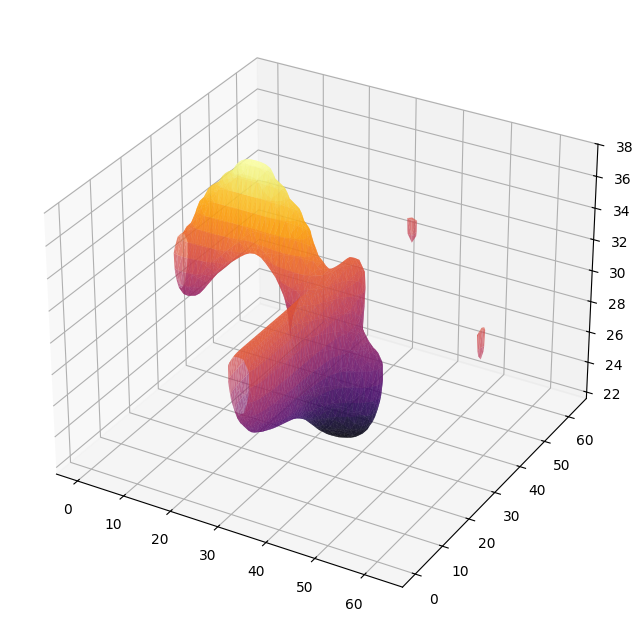

In [62]:
import numpy as np
import scipy.fftpack as fft
import scipy.ndimage as ndimage
import skimage.measure as measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from poisson_solver import poisson_solve
from zero_form import ZeroForm

# Function to compute isosurface using Marching Cubes
def extract_isosurface(u):
    """Extracts the isosurface from the scalar field u."""
    level = np.max(np.abs(u)) * 0.2  # Adaptive threshold based on max value
    verts, faces, _, _ = measure.marching_cubes(u, level=level)
    return verts, faces

# Example: Construct a vector field representing a disk in toroidal space
shape = (64, 64, 64)  # Grid resolution
X = np.zeros((*shape, 3))  # Initialize vector field to zero
V_ind = X[:]

# Define parameters for an L-shaped frame with smooth curve
center = np.array([0.5, 0.5, 0.5])  # Center in unit cube coordinates
thickness = 0.05  # Frame thickness in unit cube scale
width = 0.15  # Frame width in unit cube scale
height_variation = 0.1  # Variation in Z direction

# Convert to grid coordinates
center_grid = (center * shape).astype(int)
thickness_grid = max(1, int(thickness * shape[2]))
width_grid = int(width * shape[0])

# Create an L-shape with a curve in toroidal space
for x in range(shape[0]):
    for y in range(shape[1]):
        for z in range(shape[2]):
            # Define L-shape segments with a sinusoidal height variation
            in_vertical = (x >= center_grid[0] - thickness_grid // 2) and (x <= center_grid[0] + thickness_grid // 2) and (y <= center_grid[1] + width_grid)
            in_horizontal = (y >= center_grid[1] - thickness_grid // 2) and (y <= center_grid[1] + thickness_grid // 2) and (x <= center_grid[0] + width_grid)
            
            if in_vertical or in_horizontal:
                height_offset = int(height_variation * shape[2] * np.sin(2 * np.pi * x / shape[0]))  # Sinusoidal Z variation
                z_shifted = (center_grid[2] + height_offset) % shape[2]  # Ensure periodicity
                X[x, y, z_shifted, :] = np.array([0, 0, 1])  # Normal points along Z

# Compute divergence with periodic derivatives
def periodic_derivative(field, axis):
    return (np.roll(field, -1, axis=axis) - np.roll(field, 1, axis=axis)) / 2

div_X = (periodic_derivative(X[..., 0], axis=0) +
         periodic_derivative(X[..., 1], axis=1) +
         periodic_derivative(X[..., 2], axis=2))

# Solve Poisson equation Δu = -div_X
div_X_form = ZeroForm(V_ind, scalar_field=-div_X)
u = poisson_solve(div_X_form)

# Plot the magnitude of u as a debugging tool
plt.figure(figsize=(8, 6))
plt.imshow(np.abs(u[:, :, shape[2] // 2]), cmap='inferno', origin='lower')
plt.colorbar(label='|u| Magnitude')
plt.title('Magnitude of u at z = center')
plt.show()

# Extract isosurface
verts, faces = extract_isosurface(u)

# Check if isosurface extraction is valid
if verts.shape[0] == 0:
    print("Warning: No valid isosurface extracted. Check level set selection.")

# Plot the extracted isosurface
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces, cmap='inferno', alpha=0.7)
plt.show()